In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import re
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2023-01-15 03:45:39.713611: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-15 03:45:39.713796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Device: grpc://10.0.0.2:8470


2023-01-15 03:45:46.353455: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-15 03:45:46.357444: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-15 03:45:46.357492: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-15 03:45:46.357525: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eb2da5be10ad): /proc/driver/nvidia/version does not exist
2023-01-15 03:45:46.360607: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('chest-xray-pneumonia')
BATCH_SIZE = 64*strategy.num_replicas_in_sync
#BATCH_SIZE = 64 # for non-TPU use
IMAGE_SIZE = [180, 180]
EPOCHS = 50

In [4]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/test/*/*')))

print(f'The total number of files is {len(filenames)}')

2023-01-15 03:45:52.094096: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-15 03:45:52.204546: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-15 03:45:52.305438: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-15 03:45:52.402690: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-15 03:45:52.493888: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


The total number of files is 5856


2023-01-15 03:45:53.424800: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-15 03:45:53.494195: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
# split the data into 60:40 for train:test+val
train_files, val_test_files = train_test_split(filenames, test_size=0.4,random_state=18)

In [6]:
# split the val_test_files to 50:50 to have a final split of 60:20:20 of train:val:test
val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=18)

In [7]:
pct_df = pd.DataFrame(columns = ['data_set', 'label', 'pct'], index = range(6))

totals = {'train':len(train_files), 'val':len(val_files), 'test':len(test_files)}


re_pattern = '.*/(NORMAL|PNEUMONIA)/.*'


test_pneum_count = 0
test_norm_count = 0
for file in test_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        test_norm_count += 1
    else:
        test_pneum_count += 1

pct_df.iloc[2, :] = ['test', 'NORMAL', round(100* test_norm_count / totals['test'], 1)]
pct_df.iloc[3, :] = ['test', 'PNEUMONIA', round(100* test_pneum_count / totals['test'], 1)]



In [8]:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_files)

#view the file paths for training
print('----Testing Files----')
for f in test_list_ds.take(5):
    print(f.numpy())

----Testing Files----
b'gs://kds-4d40db045e37c7ef8a36d6829892b44c7a9fe6fc766dd777c2adbdcf/chest_xray/train/PNEUMONIA/person1519_bacteria_3970.jpeg'
b'gs://kds-4d40db045e37c7ef8a36d6829892b44c7a9fe6fc766dd777c2adbdcf/chest_xray/train/NORMAL/NORMAL2-IM-0529-0001.jpeg'
b'gs://kds-4d40db045e37c7ef8a36d6829892b44c7a9fe6fc766dd777c2adbdcf/chest_xray/train/PNEUMONIA/person860_virus_1505.jpeg'
b'gs://kds-4d40db045e37c7ef8a36d6829892b44c7a9fe6fc766dd777c2adbdcf/chest_xray/train/PNEUMONIA/person51_bacteria_248.jpeg'
b'gs://kds-4d40db045e37c7ef8a36d6829892b44c7a9fe6fc766dd777c2adbdcf/chest_xray/train/NORMAL/IM-0201-0001.jpeg'


In [9]:
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

2023-01-15 03:45:53.841828: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 24, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673754353.838442653","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 24, Output num: 0","grpc_status":3}


In [10]:
# will label as 1 if pneumonia otherwise 0
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
y_test = []
for image, label in test_ds.take(TEST_IMG_COUNT):
    y_test.append(label)
    
print('Test Counts')
print(f'Pneumonia count: {np.sum(y_test)}\nNormal count: {TEST_IMG_COUNT - np.sum(y_test)}')

Test Counts
Pneumonia count: 849
Normal count: 323


In [13]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [14]:
# create some metrics for comparing on test results

def precision(y_test, y_pred):
    tp, fp = 0, 0
    
    for i in range(len(y_test)):
        if y_test[i] >= 0.5 and y_pred[i] >= 0.5:
            tp += 1
        elif y_test[i] < 0.5 and y_pred[i] >= 0.5:
            fp += 1
            
    return tp / (tp + fp)

def recall(y_test, y_pred):
    tp, fn = 0, 0
    
    for i in range(len(y_test)):
        if y_test[i] >= 0.5 and y_pred[i] >= 0.5:
            tp += 1
        elif y_test[i] >= 0.5 and y_pred[i] < 0.5:
            fn += 1
            
    return tp / (tp + fn)

def f1_score(y_test, y_pred):
    numerator = precision(y_test, y_pred) * recall(y_test, y_pred)
    denominator = precision(y_test, y_pred) + recall(y_test, y_pred)
    
    return 2 * (numerator / denominator)

In [15]:
filepath_list = []

for dirname, _, filenames in os.walk('/kaggle/input/pneumonia-x-ray-models'):
    for filename in filenames:
        if filename not in filepath_list:
            
            print(f'\n\nModel {filename} results:')
            
            saveModelPath = '../input/pneumonia-x-ray-models/' + filename
            filepath_list.append(saveModelPath)
            model = tf.keras.models.load_model(saveModelPath)

            
            test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
            test_ds = test_ds.batch(BATCH_SIZE)
            
            y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)
            y_preds = y_preds.reshape(-1)
            y_actual = [1 if x == True else 0 for x in y_test]
            
            print(f'Test Recall: {recall(y_actual, y_preds)}')
            print(f'Test Precision: {precision(y_actual, y_preds)}')
            print(f'Test F1 Scores: {f1_score(y_actual, y_preds)}\n\n')



Model densenet_0.062059600512000004_3880_256_1layer_34_0.89_xray_model.h5 results:
3/3 [==============================] - 33s 15s/step
Test Recall: 0.9681978798586572
Test Precision: 0.9670588235294117
Test F1 Scores: 0.9676280164802825




Model densenet_0.06103_4096_256_1layer_34_0.97_xray_model.h5 results:
3/3 [==============================] - 32s 15s/step
Test Recall: 0.9705535924617197
Test Precision: 0.9728453364817001
Test F1 Scores: 0.9716981132075472




Model densenet_0.0638096812464384_3570_256_1layer_34_0.79_xray_model.h5 results:
3/3 [==============================] - 32s 15s/step
Test Recall: 0.9729093050647821
Test Precision: 0.9649532710280374
Test F1 Scores: 0.9689149560117302




Model densenet_0.062059600512000004_3724_256_1layer_34_0.79_xray_model.h5 results:
3/3 [==============================] - 32s 15s/step
Test Recall: 0.9693757361601885
Test Precision: 0.9716646989374262
Test F1 Scores: 0.9705188679245284




Model densenet_0.06103_4096_256_1layer_34_0.9_xra

In [16]:
model = tf.keras.models.load_model('../input/pneumonia-x-ray-models/densenet_0.058588799999999996_4218_256_1layer_34_0.84_xray_model.h5')
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
            
y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)
y_preds = y_preds.reshape(-1)

3/3 [==============================] - 32s 15s/step


In [17]:
fpr, tpr, thresholds = roc_curve(y_actual, y_preds, pos_label=1)
print(f'AUC score: {auc(fpr, tpr)}')

AUC score: 0.990128616073545


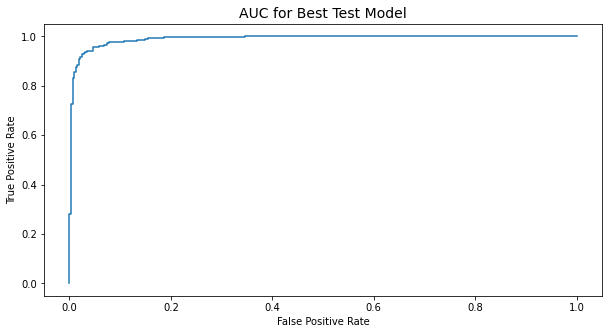

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUC for Best Test Model', fontsize=14)
plt.show()